In [8]:
import tensorflow as tf

import os
import keras
from tensorflow.keras import datasets, layers, models
from tensorflow.keras.initializers import RandomNormal
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
from matplotlib import image
from skimage import data, color
from skimage.transform import rescale, resize, downscale_local_mean
import matplotlib.pyplot as plt

from sklearn.model_selection import train_test_split
import sklearn
from PIL import Image, ImageFont, ImageDraw, ImageEnhance

# Vytvoření RoI

In [9]:
# funkce pro vytvoreni RoI a datasetu pro nasledujici praci
def createBoundingBoxes(img_id, targets, rangeX = (0,7), rangeY = (0,7)):
  step = 224/14
  df = pd.DataFrame({'img_id': [],'x0P' : [], 'y0P' : [], 'w' : [], 'h':[],'x0' : [],'y0':[],'x1' : [],'y1':[],
                     'xr0' : [], 'yr0' : [], 'xr1' : [], 'yr1' : [], 'tx' : [], 'ty' : [], 'tw' : [], 'th' : [],'iou' :[], 'pred': []})

  for w in range(rangeX[0],rangeX[1]):
    w += 1
    for h in range(rangeY[0], rangeY[1]):
      h += 1

      for i in range(14 - w + 1):
        for j in range(14 - h + 1):
          x0P = i
          y0P = j

          x0 = x0P * step
          y0 = y0P * step
          x1 = x0 + w * step
          y1 = y0 + h * step
          width = abs(x0 - x1)
          height = abs(y0 - y1)
          cx = x0 + width/2
          cy = y0 + height/2
          c = np.array([cx,cy])
          
          highest = 0
          for pos in targets:
            _t_x0 = pos[0]
            _t_y0 = pos[1]
            _t_width = pos[2]
            _t_height = pos[3]
            _t_x1 = _t_x0 + _t_width
            _t_y1 = _t_y0 + _t_height
            _t_c = np.array( [_t_x0 + _t_width/2, _t_y0 + _t_height/2])

            _iou = iou((x0, y0, x1, y1), (_t_x0, _t_y0, _t_x1, _t_y1))
            _iou2 = iou2((x0, y0, x1, y1), (_t_x0, _t_y0, _t_x1, _t_y1))
            print(_iou, _iou2)

            if _iou >= highest:
              IOU = _iou
              t_x0 = _t_x0
              t_y0 = _t_y0
              t_x1 = _t_x1
              t_y1 = _t_y1
              t_width = _t_width
              t_height = _t_height
              t_c = _t_c
              t_cx = t_c[0]
              t_cy = t_c[1]
              highest = IOU
          
          if IOU < 0.1:
            continue
          elif IOU < 0.5:
            pred = 0
          else:
            pred = 1

          tx = (t_cx - cx)/width
          ty = (t_cy - cy)/height
          tw = np.log(t_width/width)
          th = np.log(t_height/height)

          add =  pd.DataFrame({'img_id':[img_id] ,'x0P' : [x0P], 'y0P' : [y0P], 'w' : [w], 'h':[h],'x0' : [x0], 'y0':[y0],
                              'x1':[x1],'y1':[y1], 'xr0' : [t_x0], 'yr0' : [t_y0], 'xr1' : [t_x1], 'yr1' : [t_y1], 'tx' : [tx], 'ty' : [ty],
                               'tw' : [tw], 'th' : [th],'iou' :[IOU], 'pred': [pred]})
          
          df = df.append(add)

  return df



# funkce pro vypocet IoU dvou obdelniku
def iou(a, b):
    if a[0] >= a[2] or a[1] >= a[3] or b[0] >= b[2] or b[1] >= b[3]:
        return 0.0

    x = max(a[0], b[0])
    y = max(a[1], b[1])
    w = min(a[2], b[2]) - x
    h = min(a[3], b[3]) - y
    
    area_i =  w*h
    if w < 0 or h < 0:
      area_i = 0
    
    area_a = (a[2] - a[0]) * (a[3] - a[1])
    area_b = (b[2] - b[0]) * (b[3] - b[1])
    area_u = area_a + area_b - area_i

    return float(area_i) / float(area_u)



In [ ]:
# nacteni pozic hracu a vypocet vytvoreni zakladniho datasetu pro praci
f = open('data/pos.txt','r').read()
lines = f.split('\n')

img_id = 1
buff = []
df = -1

for l in lines:
  coords = l.split(' ')
  if len(coords) == 1 and coords[0] == '1':
    continue
  
  if len(coords) == 1:
    if type(df) == int:
      df = createBoundingBoxes(img_id, buff, (0,7),(0,7))   
    else:
      df = df.append(createBoundingBoxes(img_id, buff, (0,7),(0,7))) 
      if coords[0] == '-':
        break
    buff = []
    img_id = coords[0]
    continue
  
  buff.append([int(coords[0]),int(coords[1]),int(coords[2]),int(coords[3])])

In [14]:
# ziskani trenovaci mnoziny
df = df.sample(frac=1)
dfs = df[df['pred']==1]
df = dfs.append(df[(df['pred']==0) & (df['iou']>0.1)].head(1*dfs.shape[0]))
df = df.sample(frac=1)
df['img_id'] = df['img_id'].astype('int32')
df = df.sort_values(by = ['img_id'])
df.index = list(range(df.shape[0]))
df.shape

(982, 20)

# Vytvoření modelu

In [15]:
# vlastni tf vrstva pro RoI pooling
class ROIPoolingLayer(layers.Layer):
  def __init__(self):
    super(ROIPoolingLayer, self).__init__()

  def call(self, X): 
    pool_width = 7
    pool_height = 7
    layers = X[0][0]
    x = X[1][0][0]
    y = X[1][0][1]
    width = X[1][0][2]
    height = X[1][0][3]

    x = tf.cast(x,'int32')
    y = tf.cast(y,'int32')
    width = tf.cast(width,'int32')
    height = tf.cast(height,'int32')

    crop = tf.image.crop_to_bounding_box(layers, x, y, width, height)
    rs = tf.image.resize(crop, (7,7), method = 'nearest')

    return tf.expand_dims(rs, axis = 0)


# cast Fast-RCNN nasledujici po pooling vrstve
def createModel():
  inputVGG = layers.Input(shape=(14,14,512))
  inputCoords = layers.Input(shape = (4))
  roiPool = ROIPoolingLayer()([inputVGG, inputCoords])

  reg = 0.0
  reg2 = 0.00
  
  x = layers.Flatten()(roiPool)
  x = layers.Dense(4096, activation='relu', 
                   bias_regularizer=tf.keras.regularizers.L1(reg2),
                   kernel_regularizer=tf.keras.regularizers.L1(reg))(x)
  branch = layers.Dense(4096, activation='relu', 
                        bias_regularizer=tf.keras.regularizers.L1(reg2),
                        kernel_regularizer=tf.keras.regularizers.L1(reg))(x)

  clasif = layers.Dense(2, activation='softmax', bias_regularizer=tf.keras.regularizers.L1(reg2),
                        kernel_regularizer=tf.keras.regularizers.L1(reg),
                        kernel_initializer=RandomNormal(stddev=0.01))(branch)

  reg = layers.Dense(4, activation='linear', 
                     bias_regularizer=tf.keras.regularizers.L1(reg2),
                     kernel_regularizer=tf.keras.regularizers.L1(reg),
                     kernel_initializer=RandomNormal(stddev=0.001))(branch) 

  output = layers.concatenate([reg, clasif])
  model = models.Model([inputVGG, inputCoords], output)
  return model

In [16]:
# vlastni model pro klasifikaci a regresi RoI zadanych v poli coords

class myModel(tf.keras.Model):
  def __init__(self, p_vgg, rcnn_module):
    super(myModel, self).__init__()
    self.p_vgg = p_vgg
    self.rcnn_module = rcnn_module 
    self.first = True
    self.p_vgg.trainable = True


  def call(self, img, coords):
    self.feature_map = self.p_vgg(img)
    
    ret = []
    for c in coords:
      #ret = self.rcnn_module([feature_map, c])
      c = tf.convert_to_tensor([c])
      ret.append(self.rcnn_module([self.feature_map, c]))

    return ret



vgg = tf.keras.applications.VGG16()
p_vgg = tf.keras.Model(inputs = vgg.layers[0].input, outputs = vgg.layers[17].output)
rcnn_module = createModel()

model = myModel(p_vgg, rcnn_module)

553467904/553467096 [==============================] - 22s 0us/step


# Načtení obrázků

In [18]:
# nacteni trenovacich obrazku

def loadImages():
  imgs = []
  for i in list(range(1,37)):
    img = getImageTensor('data/' +  str(i) + '.png')
    img = tf.expand_dims(img, axis=0)
    imgs.append(img)

  return imgs

def getImageTensor(img_name):
  img = Image.open(img_name)
  img = np.array(img)
  imgt = tf.convert_to_tensor(img)

  return imgt

imgs = loadImages()

# Trénování modelu

In [ ]:
# ztratova funkce Fast R-CNN
def loss_func(x,y):
  def huber_loss(x):
      if tf.math.abs(x) < 1.0:
        return 0.5*x*x
      return (tf.math.abs(x) - 0.5)

  def loss(tx, ty, tw, th, p0, p1, txe, tye, twe, the, ce):
    txd = huber_loss(txe - tx)
    tyd = huber_loss(tye - ty)
    twd = huber_loss(twe - tw)
    thd = huber_loss(the - th)
    
    if ce == 0:
      return - tf.math.log(p0)
    else:
      return - tf.math.log(p1) + 5*(txd + tyd + twd + thd)

  lossSum = 0

  for i in range(len(x)):
    res = x[i][0]
    ref = y[i]
    #print(res)
    #print(ref)
    pl = loss(res[0], res[1], res[2], res[3], res[4], res[5],
                    ref[0], ref[1], ref[2], ref[3], ref[4])
    #print('pl',pl)
    #print('---')

    lossSum += pl
  
  return lossSum


def prepareBatches(df):
  batches = []
  sum = 0
  for id in df['img_id'].unique():
    cnt = df[df['img_id']==id].shape[0]
    batches.append((id,cnt))
    sum+=cnt
  print(sum)
  return batches

In [ ]:
# custom loop pro trenovani

tf.random.set_seed(42)
batches = prepareBatches(df)


optimizer = keras.optimizers.SGD(learning_rate=0.00001)
epochs = 100
refCols = df[['tx','ty','tw','th','pred']]


train_err = []
test_err = []


for e in range(epochs):
  loss_sum = 0 
  train_loss_sum = 0

  i = 0
  for b in batches:
    img_id = b[0]
    batch_size = b[1]
    img = imgs[img_id-1]

    fromm = i
    to = i+batch_size-1
    coords = np.array(df.loc[fromm:to,'x0P':'h'])
    y = tf.convert_to_tensor( refCols.loc[fromm:to, :], dtype = tf.float32)

    with tf.GradientTape() as tape:
        logits = model(img, coords , training=True)  # Logits for this minibatch
        loss_value = loss_func(logits, y)
        
        
    if img_id < 31:
      loss_sum += loss_value
      grads = tape.gradient(loss_value, model.trainable_weights)
      optimizer.apply_gradients(zip(grads, model.trainable_weights))
    else:
      train_loss_sum += loss_value

    i += batch_size

  train_avg = loss_sum/df[df['img_id']<40].shape[0]
  test_avg = train_loss_sum/df[df['img_id']>=30].shape[0]
  print('Error:', loss_sum.numpy(), 'Average error:', train_avg.numpy())
  train_err.append(train_avg.numpy())
  test_err.append(test_avg.numpy())

# Převod výstupních atributů na souřadnice

In [ ]:
# funkce pro prepocet predikovanych hodnot z modelu na souradnice v obrazku

def convertOutput(x0, y0, x1, y1, txp, typ, twp, thp):
  width = abs(x1-x0)
  height = abs(y1-y0)
  xc = x0 + width/2
  yc = y0 + height/2
  #print('width',width)

  xcp = txp * width + xc
  ycp = typ * height + yc
  widthp = np.exp(twp) * width
  heightp = np.exp(thp) * height

  x0 = xcp - widthp/2
  y0 = ycp - heightp/2
  x1 = xcp + widthp/2
  y1 = ycp + heightp/2  

  return [x0, y0, x1, y1, xc, xcp]

In [ ]:
# prepocet predikovanych hodnot z modelu na souradnice v obrazku 

df['x0p'] = -1
df['y0p'] = -1
df['x1p'] = -1
df['y1p'] = -1
df['p1p'] = -1

sum = 0
for i in df[df['img_id']<31].index: #range(df.shape[0]):
  p_sum = 0
  coords = np.array([df.loc[i,'x0P':'h']])

  pred = model(img, coords, training = False)

  txp = float(pred[0][0][0])
  typ = float(pred[0][0][1])
  twp = float(pred[0][0][2])
  thp = float(pred[0][0][3])
  p1p = float(pred[0][0][5])


  x0 = df.loc[i,'x0']
  y0 = df.loc[i,'y0']
  x1 = df.loc[i,'x1']
  y1 = df.loc[i,'y1']

  P = convertOutput(x0, y0, x1, y1, txp, typ, twp, thp)


  df.loc[i,'x0p'] = P[0]
  df.loc[i,'y0p'] = P[1]
  df.loc[i,'x1p'] = P[2]
  df.loc[i,'y1p'] = P[3]
  df.loc[i,'p1p'] = p1p


In [ ]:
# vyfiltrovani prekryvajicich se predikovanych oblasti pomoci non-maximum suppresion -
# zahazujeme oblasti, ktery maji IoU vetsi nez 0.3 s jinou oblasti s mensi klasifikacni hodnotou

df['dis']=False
df.sort_values(by =['p1p'])

for i in range(df.shape[0]):
  if df.loc[i,'dis'] == True:
    continue

  for j in range(i+1, df.shape[0]):
    if df.loc[j,'dis'] == True or df.loc[i,'img_id'] != df.loc[j,'img_id']:
      continue

    rect1 = (df.loc[i,'x0p'], df.loc[i,'y0p'], df.loc[i,'x1p'], df.loc[i,'y1p'])
    rect2 = (df.loc[j,'x0p'], df.loc[j,'y0p'], df.loc[j,'x1p'], df.loc[j,'y1p'])

    if iou(rect1, rect2) > 0.3:
      df.loc[j, 'dis'] = True

df = df[df['dis']==False]

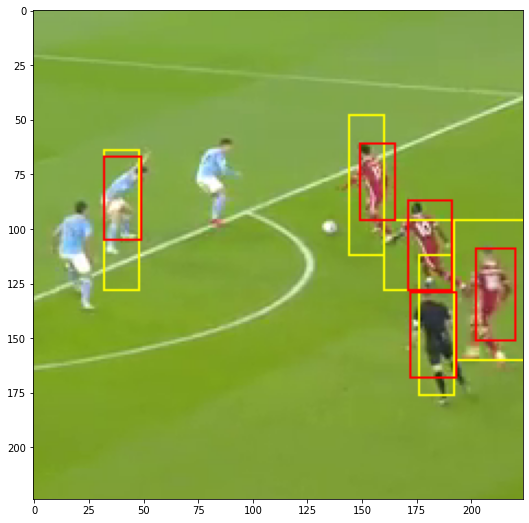

In [82]:
# puvodnich RoI a upravenych RoI pomoci modelu

source_img = Image.open('images/30.png')

draw = ImageDraw.Draw(source_img)

for i in  df[df['img_id']==30].index:
  if df.loc[i,'p1p'] > 0.5:
    draw.rectangle([(df.loc[i,'x0'],df.loc[i,'y0']),(df.loc[i,'x1'],df.loc[i,'y1'])],outline='yellow')
    draw.rectangle([(df.loc[i,'x0p'],df.loc[i,'y0p']),(df.loc[i,'x1p'],df.loc[i,'y1p'])],outline='red')

plt.figure(figsize=(16,9))
plt.imshow(source_img)
plt.show()